In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_HIGHTOL.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv_HIGHTOL.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [2]:
# Full 6D r,v elements

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545489,15563.916192,266.913396,-1.142984,2.852848,0.048528
2,30572.240101,28909.065576,496.928457,-2.127756,2.228986,0.039518
3,17596.058985,38144.724801,671.355898,-2.813645,1.287414,0.027234
4,2068.443209,41949.722913,775.646911,-3.098444,0.161674,0.012698
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


Function to train model on ONE column:

In [6]:
#Function

def train_vector(df, str):
    
    #Create a new dataframe with only the column
    data = df.filter([str]) # CHANGE FOR Y,Z
    #Convert the dataframe to a numpy array
    dataset = data.values
    #Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * 0.8 ))
    train=dataset[0 : training_data_len]
    test=dataset[training_data_len - 60 : ]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train)
    test_data=scaler.transform(test)
    
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            pass
            #print(x_train)
            #print(y_train)
            #print()      
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Create the testing data set
    #Create a new array containing scaled values
    #Create the data sets x_test and y_test
    x_test = []
    #y_test = dataset[training_data_len:, :]
    y_test = dataset[training_data_len : ]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    
    #Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(x_train, y_train, batch_size=256, epochs=100) # 10 epochs
    
    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    #print(predictions)
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    # Init empty predictions DF
    df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])
    df_pred[str]=pred_s
    
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('\n RMSE:')
    print(rmse)
    
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Visualization of vector '+str)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel(str+'-Coord', fontsize=18)
    plt.plot(train[str])
    plt.plot(valid[[str, 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    # Error plot
    valid['Error']=abs(valid.Predictions-valid[str])/6738 # the normalization ct is taken as ISS semi-major axis
    valid.Error.plot()
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

Epoch 1/100
3/3 [==============================] - 1s 237ms/step - loss: 0.2288
Epoch 2/100
3/3 [==============================] - 1s 282ms/step - loss: 0.1582
Epoch 3/100
3/3 [==============================] - 1s 261ms/step - loss: 0.1347
Epoch 4/100
3/3 [==============================] - 1s 245ms/step - loss: 0.1404
Epoch 5/100
3/3 [==============================] - 1s 231ms/step - loss: 0.1292
Epoch 6/100
3/3 [==============================] - 1s 207ms/step - loss: 0.1179
Epoch 7/100
3/3 [==============================] - 1s 201ms/step - loss: 0.1149
Epoch 8/100
3/3 [==============================] - 1s 193ms/step - loss: 0.1030
Epoch 9/100
3/3 [==============================] - 1s 189ms/step - loss: 0.0949
Epoch 10/100
3/3 [==============================] - 1s 189ms/step - loss: 0.0803
Epoch 11/100
3/3 [==============================] - 1s 175ms/step - loss: 0.0639
Epoch 12/100
3/3 [==============================] - 1s 183ms/step - loss: 0.0395
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 128ms/step - loss: 1.4266e-04
Epoch 99/100
3/3 [==============================] - 0s 127ms/step - loss: 1.4812e-04
Epoch 100/100
3/3 [==============================] - 0s 124ms/step - loss: 1.4424e-04

 RMSE:
961.8755340012372


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


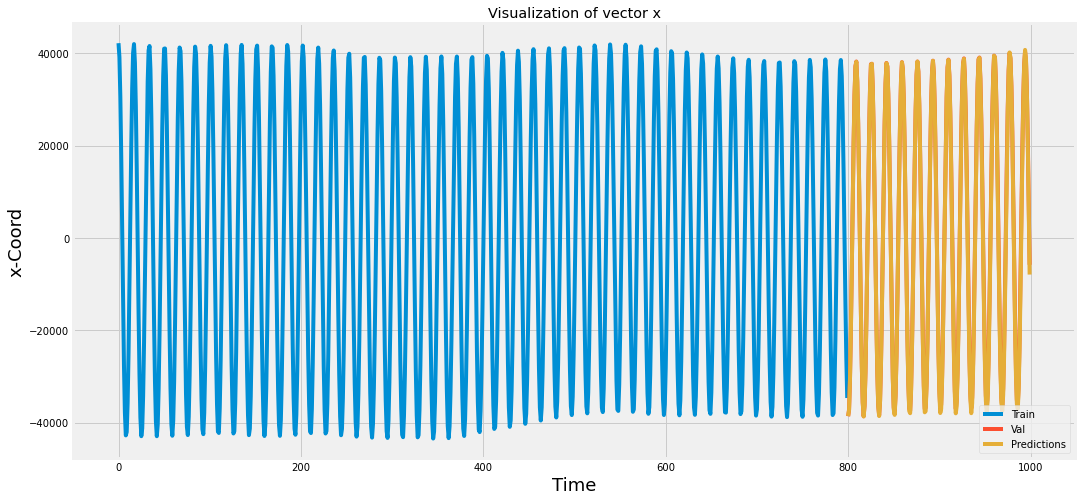

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x,y,z,x_vv,y_vv,z_vv
0,-38595.171875,NaN,NaN,NaN,NaN,NaN
1,-37229.238281,NaN,NaN,NaN,NaN,NaN
2,-30821.728516,NaN,NaN,NaN,NaN,NaN
3,-20253.882812,NaN,NaN,NaN,NaN,NaN
4,-6975.660645,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
195,38675.546875,NaN,NaN,NaN,NaN,NaN
196,31540.585938,NaN,NaN,NaN,NaN,NaN
197,20273.896484,NaN,NaN,NaN,NaN,NaN
198,6460.824707,NaN,NaN,NaN,NaN,NaN


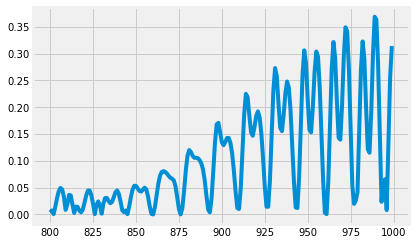

In [7]:
# Call
train_vector(df, 'x')

We want to train all the 6 separate state space elements:

In [5]:
# 6D Call:

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])

for vector in list(df.columns):
    train_vector(df, vector)

df_pred

Epoch 1/3
47/47 [==============================] - 3s 68ms/step - loss: 0.0950
Epoch 2/3
47/47 [==============================] - 3s 68ms/step - loss: 0.0018
Epoch 3/3
47/47 [==============================] - 3s 58ms/step - loss: 3.4897e-04


KeyboardInterrupt: 

In [ ]:
# Transform this df_pred to OE with the function transform.py


